# Angles dataframe calculation

### Imports


In [70]:
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

In [71]:
train_df = pd.read_csv('champs-scalar-coupling/train.csv')
test_df = pd.read_csv('champs-scalar-coupling/test.csv')
structures_df = pd.read_csv('champs-scalar-coupling/structures.csv')

In [4]:
train_df.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076


In [5]:
structures_df.head(1)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001


First step : create the adjacency matrix of the molecule. We have the position of each atom and we can obtain the radii of the bonds for each type of atom by looking on the internet, this way, we can know what which atom is connected to which. 

First we create a dictionnary with for each atom, a list $[r_{simplebond}, r_{doublebond}, r_{triplebond}]$

In [72]:
bond_radii = {'H': np.array([0.32, np.NaN, np.NaN]),
                'C': np.array([.75, .67, .60]),
                'O': np.array([.63, .57, .54]),
                'N': np.array([.71, .60, .54]),
                'F': np.array([.64, .59, .53])}

We add this information to the structures dataframe.


In [73]:
structures_df['bond_radii'] = [bond_radii[atom] for atom in structures_df['atom'].values]
structures_df.head(1)

,molecule_name,atom_index,atom,x,y,z,bond_radii
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,"[0.75, 0.67, 0.6]"


Then we need to create the adjacency matrix of the molecule, so that we can apply djikstra algorithm to find the shortest distance between each pair of atom in the train_df, and then calculate the corresponding values of cosinus angle (2 bonds between the atoms) or dihedral angle (3 bonds between the atoms). 

## First example with molecule dsgdb9nsd_003830

In [19]:
molecule_structure_df = structures_df[structures_df['molecule_name'] == 'dsgdb9nsd_003830']
molecule_structure_df

,molecule_name,atom_index,atom,x,y,z,bond_radii
53851,dsgdb9nsd_003830,0,N,-0.071679,1.327549,0.140148,"[0.71, 0.6, 0.54]"
53852,dsgdb9nsd_003830,1,C,-0.080982,0.065244,-0.016433,"[0.75, 0.67, 0.6]"
53853,dsgdb9nsd_003830,2,C,-1.239027,-0.779608,-0.079861,"[0.75, 0.67, 0.6]"
53854,dsgdb9nsd_003830,3,C,-1.079680,-2.106333,-0.250987,"[0.75, 0.67, 0.6]"
53855,dsgdb9nsd_003830,4,O,0.091584,-2.723094,-0.370290,"[0.63, 0.57, 0.54]"
53856,dsgdb9nsd_003830,5,N,1.344963,-1.829362,-0.304020,"[0.71, 0.6, 0.54]"
53857,dsgdb9nsd_003830,6,N,1.183222,-0.646421,-0.150740,"[0.71, 0.6, 0.54]"
53858,dsgdb9nsd_003830,7,H,0.889140,1.674017,0.148564,"[0.32, nan, nan]"
53859,dsgdb9nsd_003830,8,H,-2.222433,-0.341427,0.010340,"[0.32, nan, nan]"
53860,dsgdb9nsd_003830,9,H,-1.912327,-2.803604,-0.307738,"[0.32, nan, nan]"


In [45]:
def compute_adjacency_matrix(molecule_structure_df):

    nb_atoms = molecule_structure_df['atom_index'].nunique()
    
    positions = molecule_structure_df[['x', 'y', 'z']].values
    
    structure = pd.merge(molecule_structure_df, molecule_structure_df, how='outer', on=['molecule_name'], suffixes=('_0', '_1'))
    structure['distance'] = np.linalg.norm(structure[['x_0', 'y_0', 'z_0']].values - structure[['x_1', 'y_1', 'z_1']].values, axis=1)
    structure = structure[(structure.atom_index_0 > structure.atom_index_1)]
    structure['cutoff'] = (structure.distance - (structure.bond_radii_0 + structure.bond_radii_1)).apply(abs).apply(min)
    structure.sort_values('cutoff', inplace=True)

    print(nb_atoms)

    condition_bond = structure['cutoff'] < 0.2

    bonds = (structure
        .loc[condition_bond, ['atom_index_0', 'atom_index_1']]
        .drop_duplicates()
            )

    adjacency_matrix = np.zeros((nb_atoms, nb_atoms))

    for bond in bonds.iterrows():
        i, j = bond[1]['atom_index_0'], bond[1]['atom_index_1']
        adjacency_matrix[i,j] = 1
        adjacency_matrix[j, i] = 1
        
    return adjacency_matrix
                

adjacency_matrix = compute_adjacency_matrix(molecule_structure_df)

print(adjacency_matrix)

10
[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Plot a graph from the adjacency matrix

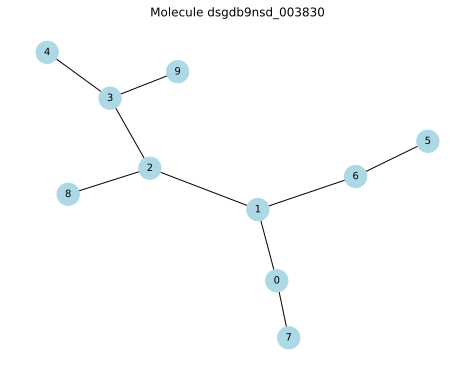

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-bright')
%config InlineBackend.figure_format = 'svg'

G = nx.Graph(adjacency_matrix)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Molecule dsgdb9nsd_003830")
plt.show()

In [54]:
def dijkstra(adjacency_matrix, atom_index0, atom_index1):
    g = nx.Graph(adjacency_matrix)
    return nx.shortest_path(g, atom_index0, atom_index1)

def cosinus(pos0, pos1, pos2):
    va = pos0 - pos1
    vb = pos2 - pos1
    va = va / np.linalg.norm(va)
    vb = vb / np.linalg.norm(vb)
    return np.round(np.dot(va, vb), 5)
    

def dihedral(x0, x1, x2, x3):
    b0 = -1.0 * (x1 - x0)
    b1 = x2 - x1
    b2 = x3 - x2

    b0xb1 = np.cross(b0, b1)
    b1xb2 = np.cross(b2, b1)

    b0xb1_x_b1xb2 = np.cross(b0xb1, b1xb2)

    y = np.dot(b0xb1_x_b1xb2, b1)*(1.0/np.linalg.norm(b1))
    x = np.dot(b0xb1, b1xb2)
    
    grad = np.arctan2(y, x)
    return grad

def get_angles(structure, atom_index_0, atom_index_1):
    shortest_path = dijkstra(adjacency_matrix, atom_index_0, atom_index_1)
    nb_bonds_shortest_path = len(shortest_path) - 1
    atoms_on_path = ''.join([structure[structure.atom_index == i].atom.values[0] for i in shortest_path[1:-1]])

    cos = dihe = None

    if nb_bonds_shortest_path == 2:
        pos0 = structure[structure.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        pos1 = structure[structure.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        pos2 = structure[structure.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        cos = cosinus(pos0, pos1, pos2)

    if nb_bonds_shortest_path == 3:
        pos0 = structure[structure.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        pos1 = structure[structure.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        pos2 = structure[structure.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        pos3 = structure[structure.atom_index == shortest_path[3]][['x', 'y', 'z']].values[0]
        dihe = dihedral(pos0, pos1, pos2, pos3)

    row = {
        'molecule_name': structure.molecule_name.values[0],
        'atom_index_0': atom_index_0,
        'atom_index_1': atom_index_1,
        'shortest_path_atoms': atoms_on_path,
        'shortest_path_n_bonds': nb_bonds_shortest_path,
        'cosinus': cos,
        'dihedral': dihe
               }
    return pd.DataFrame(row, index=[0])

df = get_angles(molecule_structure_df, 3, 6)
df
    

,molecule_name,atom_index_0,atom_index_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_003830,3,6,CC,3,None,-0.000081


## Let's do it for all the bonds listed in the train set

In [95]:
def compute_adjacency_matrix(molecule_structure_df):
    
    #Create the adjacency matrix
    
    nb_atoms = molecule_structure_df['atom_index'].nunique()
    
    positions = molecule_structure_df[['x', 'y', 'z']].values
    
    structure = pd.merge(molecule_structure_df, molecule_structure_df, how='outer', on=['molecule_name'], suffixes=('_0', '_1'))
    structure['distance'] = np.linalg.norm(structure[['x_0', 'y_0', 'z_0']].values - structure[['x_1', 'y_1', 'z_1']].values, axis=1)
    structure = structure[(structure.atom_index_0 > structure.atom_index_1)]
    structure['cutoff'] = (structure.distance - (structure.bond_radii_0 + structure.bond_radii_1)).apply(abs).apply(min)
    structure.sort_values('cutoff', inplace=True)

    condition_bond = structure['cutoff'] < 0.2

    bonds = (structure
        .loc[condition_bond, ['atom_index_0', 'atom_index_1']]
        .drop_duplicates()
            )

    adjacency_matrix = np.zeros((nb_atoms, nb_atoms))

    for bond in bonds.iterrows():
        i, j = bond[1]['atom_index_0'], bond[1]['atom_index_1']
        adjacency_matrix[i,j] = 1
        adjacency_matrix[j, i] = 1

    return adjacency_matrix

def compute_angle_for_row(molecule_name, adjacency_matrix, molecule_structure_df, atom_index_0, atom_index_1):
    
    def dijkstra(adjacency_matrix, atom_index0, atom_index1):
        g = nx.Graph(adjacency_matrix)
        return nx.shortest_path(g, atom_index0, atom_index1)
    
    def cosinus(pos0, pos1, pos2):
        va = pos0 - pos1
        vb = pos2 - pos1
        va = va / np.linalg.norm(va)
        vb = vb / np.linalg.norm(vb)
        return np.round(np.dot(va, vb), 5)
        
    
    def dihedral(x0, x1, x2, x3):
        b0 = -1.0 * (x1 - x0)
        b1 = x2 - x1
        b2 = x3 - x2
    
        b0xb1 = np.cross(b0, b1)
        b1xb2 = np.cross(b2, b1)
    
        b0xb1_x_b1xb2 = np.cross(b0xb1, b1xb2)
    
        y = np.dot(b0xb1_x_b1xb2, b1)*(1.0/np.linalg.norm(b1))
        x = np.dot(b0xb1, b1xb2)
        
        grad = np.arctan2(y, x)
        return grad

    shortest_path = dijkstra(adjacency_matrix, atom_index_0, atom_index_1)
    nb_bonds_shortest_path = len(shortest_path) - 1
    atoms_on_path = ''.join([molecule_structure_df[molecule_structure_df.atom_index == i].atom.values[0] for i in shortest_path[1:-1]])

    cos = dihe = None

    if nb_bonds_shortest_path == 2:
        pos0 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        pos1 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        pos2 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        cos = cosinus(pos0, pos1, pos2)

    if nb_bonds_shortest_path == 3:
        pos0 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        pos1 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        pos2 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        pos3 = molecule_structure_df[molecule_structure_df.atom_index == shortest_path[3]][['x', 'y', 'z']].values[0]
        dihe = dihedral(pos0, pos1, pos2, pos3)

    result = {
        'molecule_name': molecule_structure_df.molecule_name.values[0],
        'atom_index_0': atom_index_0,
        'atom_index_1': atom_index_1,
        'shortest_path_atoms': atoms_on_path,
        'shortest_path_n_bonds': nb_bonds_shortest_path,
        'cosinus': cos,
        'dihedral': dihe
               }
    
    return pd.DataFrame(result, index=[0])
    

def process_arg(args):
    molecule_name = args['molecule_name']
    molecule_structure_df = structures_df[structures_df['molecule_name'] == molecule_name]
    adjacency_matrix = compute_adjacency_matrix(molecule_structure_df)
    ndxs = zip(args['atom_index_0s'], args['atom_index_1s'])
    return pd.concat([compute_angle_for_row(molecule_name, adjacency_matrix, molecule_structure_df, i, j) for i,j in ndxs])


In [ ]:
args = []

for molecule_name, df in train_df.groupby('molecule_name'):
    args.append({'molecule_name': molecule_name,
                 'atom_index_0s': df.atom_index_0.values,
                 'atom_index_1s': df.atom_index_1.values})
results = []

for arg in tqdm(args):
    result = process_arg(arg)
    results.append(result)


result = pd.concat(results)
result.to_csv('angles.csv', index=False)

print(len(result))

  1%|▌                                   | 1239/85012 [01:54<2:23:59,  9.70it/s]